In [2]:
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", names=["target", "ids", "date", "flag", "user", "text"])

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df = df.sample(160000)

In [10]:
df = df.drop(labels=["ids", "date", "flag", "user"], axis=1)

In [11]:
(df.target==0).sum(), (df.target==4).sum()

(80029, 79971)

Preprocessing

In [12]:
df['target'] = df['target'].replace(4,1)

In [13]:
df.head()

,target,text
280241,0,@Xoxxi NONE flat for the next week or so I th...
670902,0,"@Thummper08 I try my best , some think I shoul..."
1164823,1,@solamore it was a really good gig - well wort...
284305,0,Haircut place was closed
600870,0,Bad headache like I was drunk last night but I...


In [14]:
data = df['text']
labels = np.array(df['target'])

In [15]:
data.iloc[1]

'@Thummper08 I try my best , some think I should change the way I am if I want a full time ride , that made me '

In [16]:
# this function is copied from another kernel. Don't know who is the original author of it.
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)
def tweet(words):
    tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,reduce_len=True)
    tweet = tweet_tokenizer.tokenize(words)
    return tweet

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [17]:
data = data.apply(denoise_text)

In [18]:
print("Before: " + df['text'].iloc[1])
print("After: " + data.iloc[1])

Before: @Thummper08 I try my best , some think I should change the way I am if I want a full time ride , that made me 
After: try best think change way want full time ride made


In [19]:
len(data)

160000

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,
    random_state=1,
    stratify=labels)

In [21]:
# lets take 10k words in num_words
tokenizer = Tokenizer(num_words=10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)+1
VOCAB_SIZE

116409

In [22]:
maxlen = max([len(x) for x in X_train]) # return 175 which is too big for tweets data.
maxlen = 50

In [23]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = pad_sequences(train_sequences,maxlen=maxlen,padding='post',truncating='post')
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = pad_sequences(test_sequences,maxlen=maxlen,padding='post',truncating='post')

In [24]:
len(train_padded_sequences[0])

50

Data modelling

In [25]:
embedding_dim = 32

In [26]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(embedding_dim,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ])

model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            3725120   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               6272      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1

In [28]:
history = model.fit(train_padded_sequences,
    y_train,
    validation_data = (test_padded_sequences, y_test),
    epochs = 3)

Epoch 1/3
4000/4000 [==============================] - 79s 18ms/step - loss: 0.5452 - accuracy: 0.7255 - val_loss: 0.6057 - val_accuracy: 0.6426
Epoch 2/3
4000/4000 [==============================] - 75s 19ms/step - loss: 0.4829 - accuracy: 0.7715 - val_loss: 0.9243 - val_accuracy: 0.6183
Epoch 3/3
4000/4000 [==============================] - 73s 18ms/step - loss: 0.4558 - accuracy: 0.7858 - val_loss: 0.5000 - val_accuracy: 0.7627


In [48]:
print(X_test.iloc[5],'label: ;',y_test[5])

xlad hate happens though probably spam accounts getting shut tbh label: ; 0


In [49]:
tokenizer.sequences_to_texts(test_padded_sequences)[5]

'<OOV> hate happens though probably spam accounts getting shut tbh <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'

In [50]:
model.predict(test_padded_sequences)[5]

1000/1000 [==============================] - 6s 6ms/step


array([0.1939701], dtype=float32)

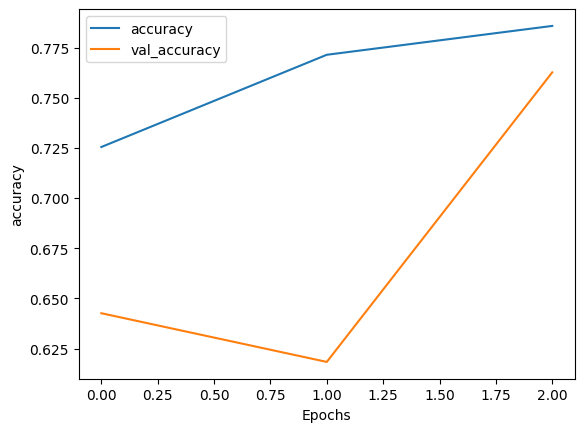

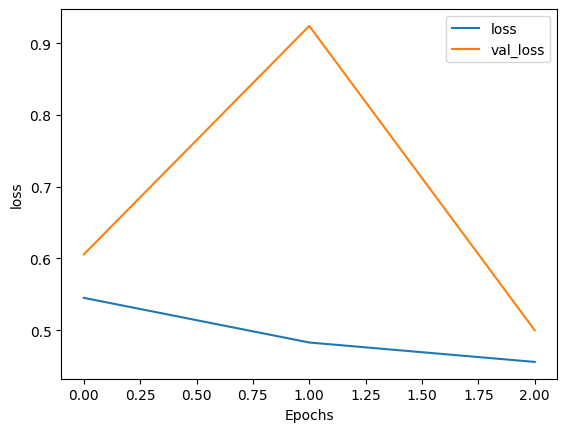

In [38]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")